# Wrangling Data From Bay Area Bike Share Published Data - Weather

### Import Packages

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import datetime

import seaborn as sns
sns.set_style('whitegrid')
sns.set_context("poster")

<p> Set some notebook variables, makes the notebook 95% width of the screen for easier viewing</p>

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

<p> Set some global font sizes for plots </p>

In [3]:
font = {'size'   : 50}
matplotlib.rc('font', **font)

LABEL_FONT_SIZE = 15
TITLE_FONT_SIZE = 25

## Import Data

In [4]:
print('Started Loading Weather Data...')
file_path_slug = '../source_data/bayareabikeshare/*_weather_data.csv'
file_list = glob(file_path_slug)

weather_df = pd.DataFrame()

counter = 1
chunks = []

for file in file_list:
    for chunk in pd.read_csv(file, chunksize=10000, iterator=True):
        chunk.columns = ['Date', 'Max_Temperature_F', 'Mean_Temperature_F', 'Min_TemperatureF', 'Max_Dew_Point_F', 
                         'MeanDew_Point_F', 'Min_Dewpoint_F', 'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 
                         'Max_Sea_Level_Pressure_In', 'Mean_Sea_Level_Pressure_In', 'Min_Sea_Level_Pressure_In', 
                         'Max_Visibility_Miles', 'Mean_Visibility_Miles', 'Min_Visibility_Miles', 
                         'Max_Wind_Speed_MPH', 'Mean_Wind_Speed_MPH', 'Max_Gust_Speed_MPH', 'Precipitation_In', 
                         'Cloud_Cover', 'Events', 'Wind_Dir_Degrees', 'zip']
        chunks.append(chunk)
    print('\tfinished file! (%d of %d)'% (counter, len(file_list)))
    counter += 1

weather_df = pd.concat(chunks)
print('Data Loaded Successfully!')

Started Loading Weather Data...
	finished file! (1 of 4)
	finished file! (2 of 4)
	finished file! (3 of 4)
	finished file! (4 of 4)
Data Loaded Successfully!


# Clean Data

In [5]:
# clean column names, remove white spaces
weather_df.columns = [col.replace(' ', '_').lower() for col in weather_df.columns]

# convert dates to proper formats and datetime objects
weather_df['date'] = pd.to_datetime(weather_df['date'], format='%m/%d/%Y')

# extract only columns we wish to keep
important_cols = ['date', 'max_temperature_f', 'mean_temperature_f', 'min_temperaturef',
                  'max_wind_speed_mph', 'mean_wind_speed_mph', 'max_gust_speed_mph',
                  'precipitation_in', 'cloud_cover', 'events', 'zip']

for col in weather_df.columns:
    if col not in important_cols:
        weather_df.drop(col, axis=1, inplace=True)

# rename columns
weather_df.columns = ['date', 'max_temp', 'mean_temp', 'min_temp', 
                      'max_wind', 'mean_wind', 'max_gust', 'precipitation', 
                      'cloud_cover', 'events', 'zip_code']


# Sanitize 'prcipitation' column values
weather_df.precipitation = pd.to_numeric(weather_df.precipitation, errors='coerce')
weather_df.precipitation.fillna(0.0, inplace=True)

# sort columns by 'date' and 'zip_code' and set index
weather_df.sort_values(['date', 'zip_code'], inplace=True)
weather_df.reset_index(drop=True, inplace=True)

# Write Data to File

In [6]:
weather_df.to_csv('../clean_data/bayareabikeshare/weather_data_cleaned.csv', encoding='utf-8')

***
# Preview EDA of Weather Data

In [7]:
weather_df.set_index('date', inplace=True)

In [8]:
def plot_temperature_range(df_weather, df_median, df_mean, title, x_label='Date', y_label='Temperature (°F)'):
    
    weather_range = df_weather['max_temp'] - df_weather['min_temp']
    weather_r = weather_range.to_frame()
    weather_r.columns=['range']
    
    median_range = df_median['max_temp'] - df_median['min_temp']
    median_r = median_range.to_frame()
    median_r.columns=['range']
    
    mean_range = df_mean['max_temp'] - df_mean['min_temp']
    mean_r = mean_range.to_frame()
    mean_r.columns=['range']
    
    
    ax = mean_r['range'].plot(figsize=(15,6), label='mean_range', color='m')
    median_r['range'].plot(ax=ax, label='median_range', color='k', linestyle=':')
    weather_r['range'].plot(ax=ax, label='range', linestyle='None', marker='.', color='m', alpha=0.1)

    plt.legend(['mean', 'median'],loc=1, prop={'size':10}, frameon=True)
    ax.set_ylabel('Temperature Difference (°F)')
    ax.set_ylim(0, 40)
    title_01 = '%s Weather' % title
    ax.set_title(title_01, size=TITLE_FONT_SIZE, weight='bold')
    ax.set_xlabel(x_label, size=LABEL_FONT_SIZE, weight='bold')
    ax.set_ylabel(y_label, size=LABEL_FONT_SIZE, weight='bold')
    plt.tight_layout()
    image_title = '../charts/02_%s.png' % title_01.replace(' ', '_')
    plt.savefig(image_title)
    
    
    fig = plt.subplots(figsize=(15,6))
    ax = df_mean['max_temp'].plot(label='max_rolling', color='r')
    df_mean['mean_temp'].plot(ax=ax, label='mean_rolling', color='k')
    df_mean['min_temp'].plot(ax=ax, label='min_rolling', color='b')

    plt.legend(['max', 'mean', 'min'], loc=1, prop={'size':10}, frameon=True)
    ax.set_ylabel('Temperature (°F)')
    ax.set_ylim(20, 100)
    title_02 = '%s Monthly Temperatures' % title
    ax.set_title(title_02, size=TITLE_FONT_SIZE, weight='bold')
    ax.set_xlabel(x_label, size=LABEL_FONT_SIZE, weight='bold')
    ax.set_ylabel(y_label, size=LABEL_FONT_SIZE, weight='bold')
    plt.tight_layout()
    image_title = '../charts/02_%s.png' % title_02.replace(' ', '_')
    plt.savefig(image_title)

In [9]:
def zip_to_landmark(zip):
    ''' Return landmark for given zip'''
    if zip == 94107:
        return 'San Francisco'
    if zip == 94063:
        return 'Redwood City'
    if zip == 94301:
        return 'Palo Alto'
    if zip == 94041:
        return 'Mountain View'
    if zip == 95113:
        return 'San Jose'
    return False

### San Francisco Weather

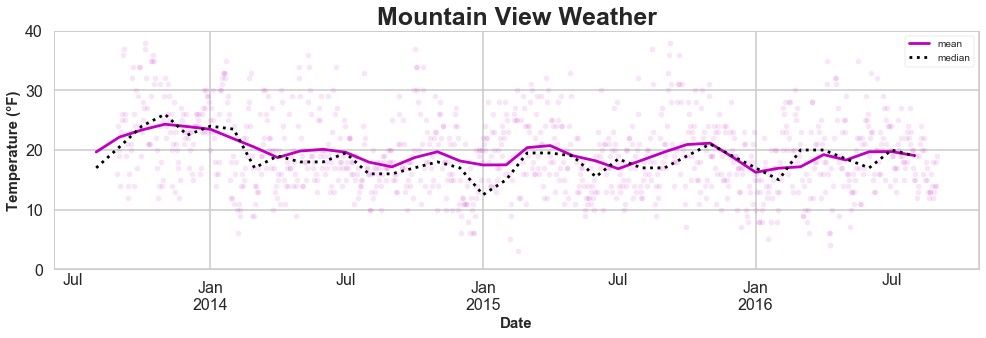

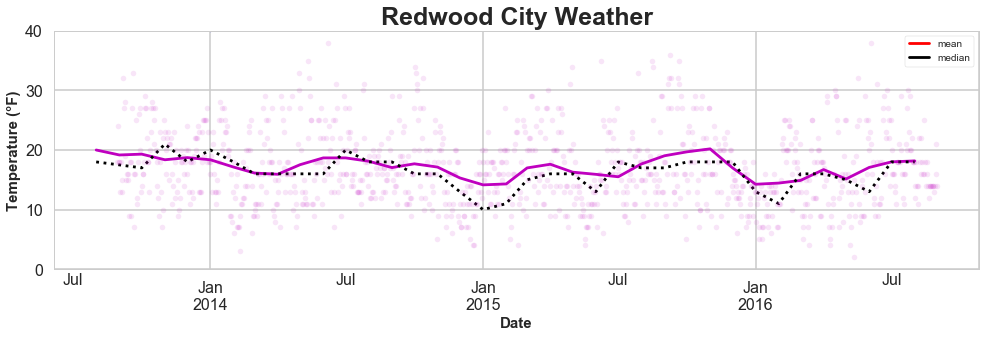

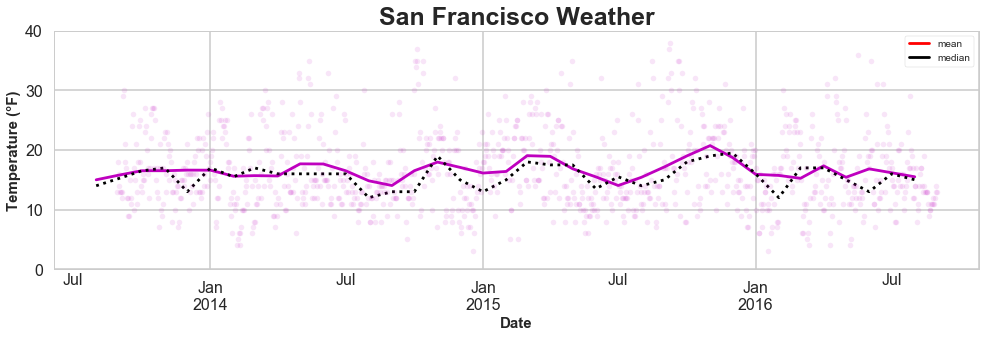

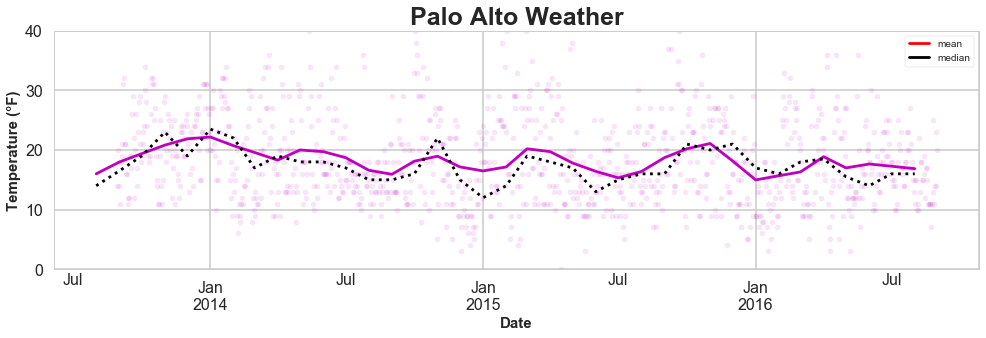

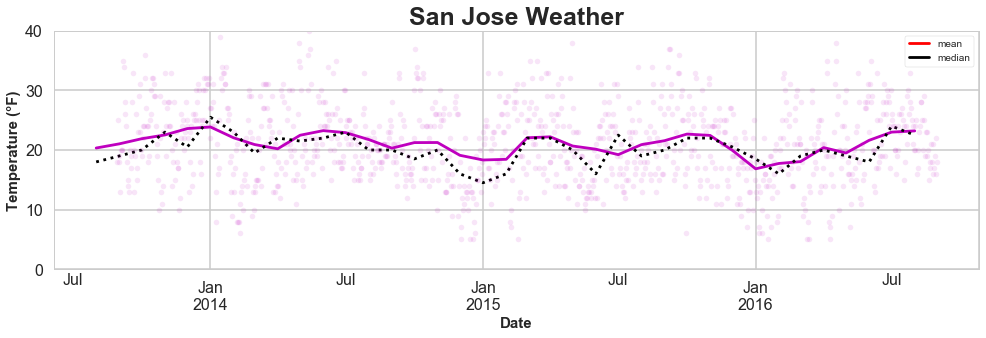

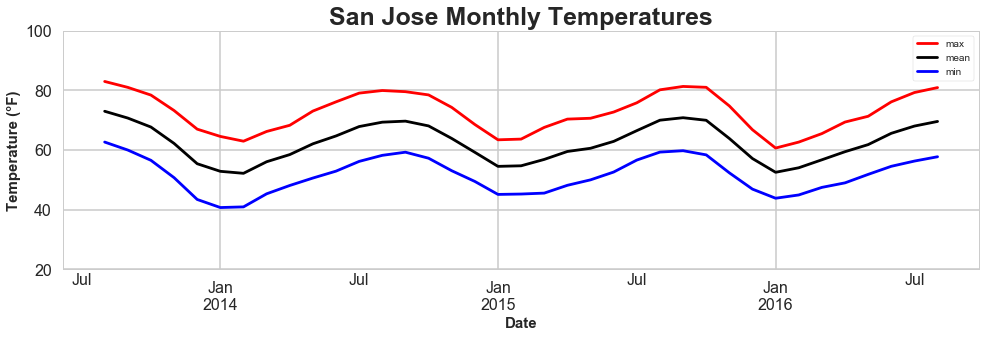

In [10]:
for zip_code in sorted(pd.unique(weather_df.zip_code)):


    df_weather = weather_df[weather_df.zip_code == zip_code]

    # resample Mean
    df_monthly_mean = df_weather.resample('M').mean()
    df_monthly_rolling_mean = df_weather.resample('M').mean().fillna(0).rolling(window=3, min_periods=1).mean()

    # resample Min
    df_monthly_min = df_weather.resample('M').min()
    df_monthly_rolling_min = df_weather.resample('M').min().fillna(0).rolling(window=3, min_periods=1).min()

    # resample Max
    df_monthly_max = df_weather.resample('M').max()
    df_monthly_rolling_max = df_weather.resample('M').max().fillna(0).rolling(window=3, min_periods=1).max()

    # resample Median
    df_monthly_median = df_weather.resample('M').median()
    df_monthly_rolling_median = df_weather.resample('M').median().fillna(0).rolling(window=3, min_periods=1).median()

    plot_temperature_range(df_weather, df_monthly_rolling_median, df_monthly_rolling_mean, zip_to_landmark(zip_code))

# Quick Reference to All Weather Data

In [11]:
weather_df.head(10)

,max_temp,mean_temp,min_temp,max_wind,mean_wind,max_gust,precipitation,cloud_cover,events,zip_code
date,,,,,,,,,,
2013-08-29,80.0,70.0,64.0,16.0,5.0,16.0,0.0,4.0,NaN,94041
2013-08-29,80.0,71.0,62.0,14.0,6.0,17.0,0.0,5.0,NaN,94063
2013-08-29,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN,94107
2013-08-29,78.0,71.0,64.0,20.0,8.0,23.0,0.0,4.0,NaN,94301
2013-08-29,81.0,72.0,63.0,16.0,7.0,24.0,0.0,4.0,NaN,95113
2013-08-30,87.0,72.0,63.0,15.0,2.0,18.0,0.0,2.0,NaN,94041
2013-08-30,86.0,74.0,62.0,15.0,2.0,17.0,0.0,2.0,NaN,94063
2013-08-30,78.0,69.0,60.0,29.0,13.0,35.0,0.0,2.0,NaN,94107
2013-08-30,84.0,74.0,64.0,20.0,6.0,23.0,0.0,2.0,NaN,94301
